**THIS NOTEBOOK IS THE FIRST ANALYSIS FOR MY PROJECT: IMPLEMENTATION OF NEURAL NETS FOR MOMENTUM TRADING STRATEGIES.
IN THIS NOTEBOOK I TRY TO PREDICT STOCK PRICES BY DIRECTLY FEEDING STOCK PRICE INTO LSTM AND GRU NETWORKS. 
READING A FEW RESEARCH PAPERS GAVE ME THE IDEA. BEFORE IMPLEMENTING ANY STRATEGIES LET'S SEE HOW CAPABLE NEURAL NETS ARE AT PREDICTING STOCK PRICES GIVE A TIME WINDOW AND TIME FRAME NECESSARY FOR MOMENTUM STRATEGY**

In [1]:
import tensorflow as tf

***unzip the data file***

In [2]:
#import zipfile as zf
#files = zf.ZipFile("Data.zip", 'r')
#files.extractall('Data')
#files.close()

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import hinge_loss

import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU, ConvLSTM2D
from keras.layers import Dropout
import keras.backend as K


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls",'Data/Stocks']).decode("utf8"))
import os
os.chdir('Data/Stocks/')

aaap.us.txt
aaba.us.txt
aac.us.txt
aal.us.txt
aamc.us.txt
aame.us.txt
aan.us.txt
aaoi.us.txt
aaon.us.txt
aapl.us.txt
aap.us.txt
aat.us.txt
aa.us.txt
aau.us.txt
aav.us.txt
aaww.us.txt
aaxn.us.txt
abac.us.txt
abax.us.txt
abb.us.txt
abbv.us.txt
abcb.us.txt
abcd.us.txt
abco.us.txt
abc.us.txt
abdc.us.txt
abeo.us.txt
abeow.us.txt
abe.us.txt
abev.us.txt
abg.us.txt
abil.us.txt
abio.us.txt
ablx.us.txt
abmd.us.txt
abm.us.txt
abr_a.us.txt
abr_b.us.txt
abr_c.us.txt
abrn.us.txt
abr.us.txt
abt.us.txt
abtx.us.txt
ab.us.txt
abus.us.txt
abx.us.txt
aby.us.txt
acad.us.txt
acbi.us.txt
acco.us.txt
accp.us.txt
acc.us.txt
acer.us.txt
acerw.us.txt
acet.us.txt
acfc.us.txt
acglo.us.txt
acglp.us.txt
acgl.us.txt
achc.us.txt
achn.us.txt
ach.us.txt
achv.us.txt
acia.us.txt
aciu.us.txt
aciw.us.txt
acls.us.txt
acmr.us.txt
acm.us.txt
acnb.us.txt
acn.us.txt
acor.us.txt
acp.us.txt
acre.us.txt
acrs.us.txt
acrx.us.txt
acsf.us.txt
acsi.us.txt
acst.us.txt
acta.us.txt
actg.us.txt
ac.us.txt
acu.us.txt
acv.us.txt
acxm.us.txt
ac

Using TensorFlow backend.


***get, manipulate and read the data files. remove , and spaces from the data and make it a csv file. Use sample of this data arbitrily as seen in code***

In [3]:
#read data
# kernels let us navigate through the zipfile as if it were a directory

# trying to read a file of size zero will throw an error, so skip them
# filenames = [x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(x) > 0]
# filenames = random.sample(filenames,1)
filenames = ['prk.us.txt', 'bgr.us.txt', 'jci.us.txt', 'aa.us.txt', 'fr.us.txt', 'star.us.txt', 'sons.us.txt', 'ipl_d.us.txt', 'sna.us.txt', 'utg.us.txt']
filenames = [filenames[1]]
print(filenames)

data = []
for filename in filenames:
    df = pd.read_csv(filename, sep=',')

    label, _, _ = filename.split(sep='.')
    df['Label'] = filename
    df['Date'] = pd.to_datetime(df['Date'])
    data.append(df)

['bgr.us.txt']


In [4]:
r = lambda: random.randint(0,255)
traces = []

for df in data:
    clr = str(r()) + str(r()) + str(r())
#     df = df.sample(n=100, replace=True)
    df = df.sort_values('Date')
#     print(df['Label'])
    label = df['Label'].iloc[0]

    trace = plotly.graph_objs.Scattergl(
        x=df['Date'],
        y=df['Close'],
        mode='line',
        line=dict(
            color = clr
        )
    )
    traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot',
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')


In [5]:
df = data[0]
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data[0]["Date"][-(2*window_len+1):])[0]

**Split the training and test set**

In [6]:

training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)


** create windows for training and testing**

In [7]:
#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

**Training the LSTM model**

Epoch 1/5
 - 27s - loss: 0.0301 - acc: 0.0025 - mean_pred: 0.0147
Epoch 2/5
 - 26s - loss: 0.0262 - acc: 0.0025 - mean_pred: 0.0184
Epoch 3/5
 - 26s - loss: 0.0254 - acc: 0.0025 - mean_pred: 0.0188
Epoch 4/5
 - 26s - loss: 0.0251 - acc: 0.0025 - mean_pred: 0.0191
Epoch 5/5
 - 26s - loss: 0.0250 - acc: 0.0025 - mean_pred: 0.0189


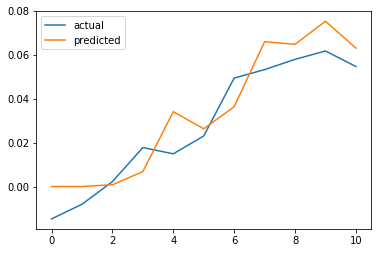

Plateau graph: 0.01020003188146837 


In [9]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)


#define lstm model
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model


#training model
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

#plot
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
plat = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('Plateau graph: {} '.format(plat))


**Prediction of one window (10 time steps) ahead*

**As can be seen in the plot below, the performance quickly degrades when predicting multiple time points ahead. However compered to something like linear regression the performance is better.**

In [10]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 21ms/step
Test accuracy: [0.010200032033026218, 0.0, 0.03394897282123566]


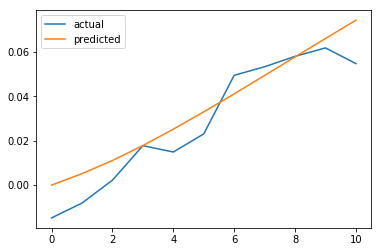

Plateau: 0.008490127397760923


In [11]:

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('Plateau: {}'.format(MAE))



In [12]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 223us/step
Test accuracy: [0.010200032033026218, 0.0, 0.03394897282123566]


**PART B: CHANGE IN ACTIVATION FUNCTION-softmax,elu and selu: great for predicting**

In [13]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using softmax function
def build_model(inputs, output_size, neurons, activ_func="softmax",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [14]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
 - 27s - loss: 0.9981 - acc: 0.0000e+00 - mean_pred: 1.0000
Epoch 2/5
 - 26s - loss: 0.9981 - acc: 0.0000e+00 - mean_pred: 1.0000
Epoch 3/5
 - 26s - loss: 0.9981 - acc: 0.0000e+00 - mean_pred: 1.0000
Epoch 4/5
 - 26s - loss: 0.9981 - acc: 0.0000e+00 - mean_pred: 1.0000
Epoch 5/5
 - 26s - loss: 0.9981 - acc: 0.0000e+00 - mean_pred: 1.0000


In [15]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 24ms/step
Test accuracy: [0.9716289639472961, 0.0, 1.0]


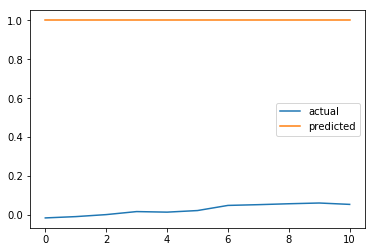

PLateau Graph: 0.9716289982468943


In [16]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('PLateau Graph: {}'.format(MAE))

**obviously softmax is not a great fit!!!!**

Epoch 1/5
 - 27s - loss: 0.0192 - acc: 0.0025 - mean_pred: 0.0022
Epoch 2/5
 - 26s - loss: 0.0149 - acc: 0.0025 - mean_pred: 0.0026
Epoch 3/5
 - 26s - loss: 0.0139 - acc: 0.0025 - mean_pred: 0.0028
Epoch 4/5
 - 26s - loss: 0.0135 - acc: 0.0025 - mean_pred: 0.0025
Epoch 5/5
 - 25s - loss: 0.0133 - acc: 0.0025 - mean_pred: 0.0024


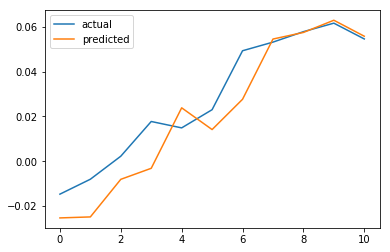

The Mean Absolute Error is: 0.009328113743642437


In [17]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using elu function
def build_model(inputs, output_size, neurons, activ_func="elu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [18]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 26ms/step
Test accuracy: [0.009328112937510014, 0.0, 0.021383747458457947]


**WOW!!!!! ELU IS AWESOME!!**

Epoch 1/5
 - 27s - loss: 0.0226 - acc: 0.0025 - mean_pred: 0.0031
Epoch 2/5
 - 26s - loss: 0.0158 - acc: 0.0025 - mean_pred: 0.0015
Epoch 3/5
 - 26s - loss: 0.0146 - acc: 0.0025 - mean_pred: 0.0018
Epoch 4/5
 - 26s - loss: 0.0142 - acc: 0.0025 - mean_pred: 0.0026
Epoch 5/5
 - 26s - loss: 0.0139 - acc: 0.0025 - mean_pred: 0.0022


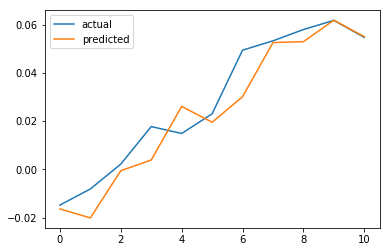

The Mean Absolute Error is: 0.00638718283860558


In [19]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using selu function
def build_model(inputs, output_size, neurons, activ_func="selu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy', mean_pred])
    return model
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [20]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 31ms/step
Test accuracy: [0.006387182045727968, 0.0, 0.024085646495223045]


slight underfiiting but not bad!!!! obviously non linear functions that predict instead of classify( have threshold values) do much better

**PART C: We have tried mean absolute error as a cost function. Now lets try the following: mean square error, hinge and logcosh property all with relu(since it has the best prediction of all)**

Epoch 1/5
 - 27s - loss: 0.0021 - acc: 0.0025 - mean_pred: 0.0165
Epoch 2/5
 - 26s - loss: 0.0019 - acc: 0.0025 - mean_pred: 0.0182
Epoch 3/5
 - 26s - loss: 0.0019 - acc: 0.0025 - mean_pred: 0.0185
Epoch 4/5
 - 26s - loss: 0.0019 - acc: 0.0025 - mean_pred: 0.0190
Epoch 5/5
 - 26s - loss: 0.0019 - acc: 0.0025 - mean_pred: 0.0188


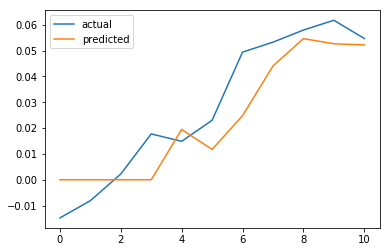

In [8]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using mean-squared_error loss function
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mse", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [9]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 23ms/step
Test accuracy: [0.00014010773156769574, 0.0, 0.02359471470117569]


Epoch 1/5
 - 28s - loss: 0.8407 - acc: 9.4637e-04 - mean_pred: 8.8650
Epoch 2/5
 - 26s - loss: 0.7457 - acc: 6.3091e-04 - mean_pred: 16.0073
Epoch 3/5
 - 26s - loss: 0.7238 - acc: 9.4637e-04 - mean_pred: 17.9640
Epoch 4/5
 - 26s - loss: 0.6928 - acc: 6.3091e-04 - mean_pred: 20.8068
Epoch 5/5
 - 26s - loss: 0.6721 - acc: 6.3091e-04 - mean_pred: 24.3747


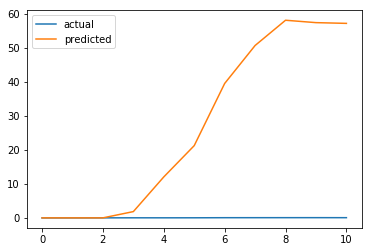

In [10]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using hinge loss function
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="hinge", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [11]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 26ms/step
Test accuracy: [0.48177796602249146, 0.0, 27.061847686767578]


Epoch 1/5
 - 28s - loss: 0.0010 - acc: 0.0025 - mean_pred: 0.0161
Epoch 2/5
 - 26s - loss: 9.5657e-04 - acc: 0.0025 - mean_pred: 0.0181
Epoch 3/5
 - 25s - loss: 9.3228e-04 - acc: 0.0025 - mean_pred: 0.0184
Epoch 4/5
 - 26s - loss: 9.1982e-04 - acc: 0.0025 - mean_pred: 0.0189
Epoch 5/5
 - 26s - loss: 9.1545e-04 - acc: 0.0025 - mean_pred: 0.0189


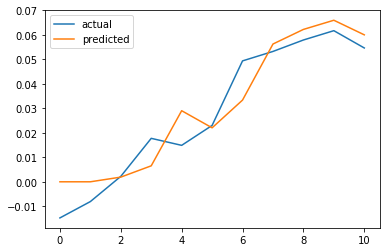

In [12]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#usinglogcosh loss functionacc is 0.00acc is 0.00
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="logcosh", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()


In [13]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 29ms/step
Test accuracy: [4.278529740986414e-05, 0.0, 0.030685149133205414]


**PART D: EPOCHS-1,5(already done), 10, 18...will be using selu instead of relu**

Epoch 1/1
 - 28s - loss: 0.0220 - acc: 0.0025 - mean_pred: 0.0020


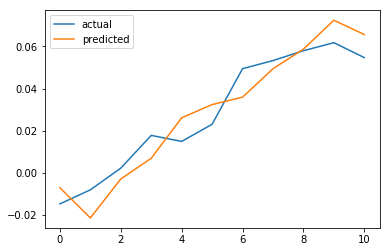

In [14]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using selu function for 1 epoch
def build_model(inputs, output_size, neurons, activ_func="selu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=1, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [15]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 31ms/step
Test accuracy: [0.00884543638676405, 0.0, 0.02871907316148281]


Epoch 1/10
 - 28s - loss: 0.0219 - acc: 0.0025 - mean_pred: 0.0026
Epoch 2/10
 - 26s - loss: 0.0160 - acc: 0.0025 - mean_pred: 0.0019
Epoch 3/10
 - 26s - loss: 0.0146 - acc: 0.0025 - mean_pred: 0.0020
Epoch 4/10
 - 26s - loss: 0.0142 - acc: 0.0025 - mean_pred: 0.0023
Epoch 5/10
 - 26s - loss: 0.0141 - acc: 0.0025 - mean_pred: 0.0023
Epoch 6/10
 - 25s - loss: 0.0138 - acc: 0.0025 - mean_pred: 0.0021
Epoch 7/10
 - 26s - loss: 0.0137 - acc: 0.0025 - mean_pred: 0.0026
Epoch 8/10
 - 26s - loss: 0.0137 - acc: 0.0025 - mean_pred: 0.0026
Epoch 9/10
 - 249s - loss: 0.0139 - acc: 0.0025 - mean_pred: 0.0022
Epoch 10/10
 - 351s - loss: 0.0136 - acc: 0.0025 - mean_pred: 0.0020


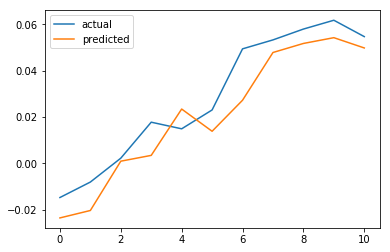

In [37]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using selu function for 10 epoch
def build_model(inputs, output_size, neurons, activ_func="selu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=10, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [38]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 8s 745ms/step
Test accuracy: [0.009150630794465542, 0.0, 0.0207718126475811]


Epoch 1/18
 - 28s - loss: 0.0210 - acc: 0.0025 - mean_pred: 0.0027
Epoch 2/18
 - 26s - loss: 0.0157 - acc: 0.0025 - mean_pred: 0.0017
Epoch 3/18
 - 26s - loss: 0.0146 - acc: 0.0025 - mean_pred: 0.0022
Epoch 4/18
 - 26s - loss: 0.0141 - acc: 0.0025 - mean_pred: 0.0018
Epoch 5/18
 - 26s - loss: 0.0139 - acc: 0.0025 - mean_pred: 0.0026
Epoch 6/18
 - 26s - loss: 0.0141 - acc: 0.0025 - mean_pred: 0.0023
Epoch 7/18
 - 25s - loss: 0.0138 - acc: 0.0025 - mean_pred: 0.0025
Epoch 8/18
 - 26s - loss: 0.0137 - acc: 0.0025 - mean_pred: 0.0024
Epoch 9/18
 - 26s - loss: 0.0136 - acc: 0.0025 - mean_pred: 0.0021
Epoch 10/18
 - 26s - loss: 0.0135 - acc: 0.0025 - mean_pred: 0.0024
Epoch 11/18
 - 26s - loss: 0.0136 - acc: 0.0025 - mean_pred: 0.0028
Epoch 12/18
 - 26s - loss: 0.0138 - acc: 0.0025 - mean_pred: 0.0022
Epoch 13/18
 - 26s - loss: 0.0136 - acc: 0.0025 - mean_pred: 0.0023
Epoch 14/18
 - 25s - loss: 0.0134 - acc: 0.0025 - mean_pred: 0.0022
Epoch 15/18
 - 26s - loss: 0.0135 - acc: 0.0025 - mean_pr

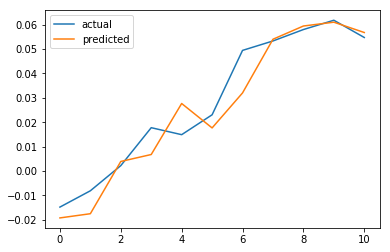

In [35]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using selu function for 18 epoch
def build_model(inputs, output_size, neurons, activ_func="selu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=18, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [36]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 1s 59ms/step
Test accuracy: [0.006096170749515295, 0.0, 0.02566787786781788]


**PART E: CHANGES IN GRADIENT ESTIMATION : WILL BE USING ELU WITH SGD, RMSPROP AND ADAGRAD. ADAM HAS ALREADY BEEN USED**

Epoch 1/5
 - 27s - loss: 0.0383 - acc: 0.0025 - mean_pred: 3.8075e-05
Epoch 2/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 3/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 4/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 5/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00


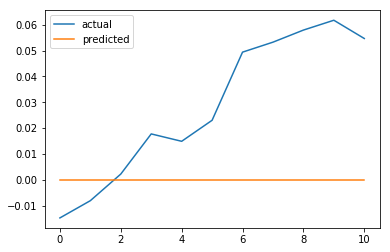

In [16]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using sgd

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="sgd"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [17]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 32ms/step
Test accuracy: [0.032524172216653824, 0.0, 0.0]


Epoch 1/5
 - 27s - loss: 0.0281 - acc: 0.0025 - mean_pred: 0.0176
Epoch 2/5
 - 25s - loss: 0.0258 - acc: 0.0025 - mean_pred: 0.0187
Epoch 3/5
 - 26s - loss: 0.0253 - acc: 0.0025 - mean_pred: 0.0192
Epoch 4/5
 - 25s - loss: 0.0251 - acc: 0.0025 - mean_pred: 0.0191
Epoch 5/5
 - 26s - loss: 0.0250 - acc: 0.0025 - mean_pred: 0.0191


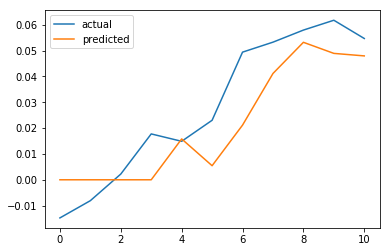

In [19]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

# using rmsprop

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [21]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 193us/step
Test accuracy: [0.01145253423601389, 0.0, 0.02123897895216942]


Epoch 1/5
 - 38s - loss: 0.0383 - acc: 0.0025 - mean_pred: 7.5709e-06
Epoch 2/5
 - 50s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 3/5
 - 56s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 4/5
 - 59s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 5/5
 - 33s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00


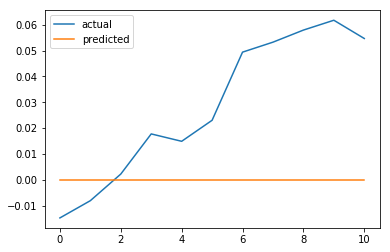

In [18]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

# using adagrad 

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adagrad"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [20]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 36ms/step
Test accuracy: [0.01145253423601389, 0.0, 0.02123897895216942]


**PART F: NETWORK ARCHITECTURE COMPARING LSTM ARCHITECTURE TO GRU, RNN AND BIDIRECTIONAL LSTM AND GRU**

In [22]:
#GRU
#Create windows for training
net_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    net_training_inputs.append(temp_set)
net_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

net_training_inputs = [np.array(net_training_input) for net_training_input in net_training_inputs]
net_training_inputs = np.array(net_training_inputs)

#Create windows for testing
net_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    net_test_inputs.append(temp_set)
net_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

net_test_inputs = [np.array(net_test_inputs) for net_test_inputs in net_test_inputs]  
net_test_inputs = np.array(net_test_inputs)

Epoch 1/5
 - 22s - loss: 0.0284 - acc: 0.0025 - mean_pred: 0.0163
Epoch 2/5
 - 20s - loss: 0.0258 - acc: 0.0025 - mean_pred: 0.0190
Epoch 3/5
 - 21s - loss: 0.0254 - acc: 0.0025 - mean_pred: 0.0193
Epoch 4/5
 - 21s - loss: 0.0252 - acc: 0.0025 - mean_pred: 0.0191
Epoch 5/5
 - 21s - loss: 0.0252 - acc: 0.0025 - mean_pred: 0.0192


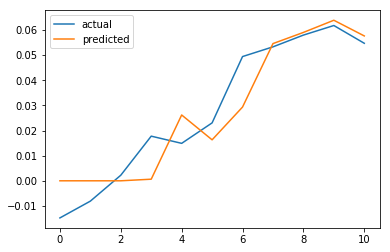

In [23]:
def mean_pred(net_test_inputs, net_test_outputs):
    return K.mean(net_test_outputs)

# using rmsprop

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(GRU(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(net_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(net_training_inputs, net_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(net_test_outputs, label = "actual")
plt.plot(nn_model.predict(net_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [24]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 36ms/step
Test accuracy: [0.00796686764806509, 0.0, 0.027948670089244843]


Epoch 1/5
 - 28s - loss: 0.0383 - acc: 0.0025 - mean_pred: 1.1785e-05
Epoch 2/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 4.4526e-07
Epoch 3/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 4/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 5/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00


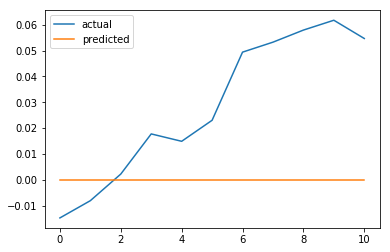

In [25]:
#bidirectional lstm 
def mean_pred(net_test_inputs, net_test_outputs):
    return K.mean(net_test_outputs)

# using rmsprop

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(LSTM(neurons, go_backwards = True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(net_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(net_training_inputs, net_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(net_test_outputs, label = "actual")
plt.plot(nn_model.predict(net_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [26]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 42ms/step
Test accuracy: [0.032524172216653824, 0.0, 0.0]


Epoch 1/5
 - 22s - loss: 0.0307 - acc: 0.0025 - mean_pred: 0.0162
Epoch 2/5
 - 21s - loss: 0.0285 - acc: 0.0025 - mean_pred: 0.0170
Epoch 3/5
 - 21s - loss: 0.0281 - acc: 0.0025 - mean_pred: 0.0171
Epoch 4/5
 - 21s - loss: 0.0278 - acc: 0.0025 - mean_pred: 0.0174
Epoch 5/5
 - 21s - loss: 0.0274 - acc: 0.0025 - mean_pred: 0.0182


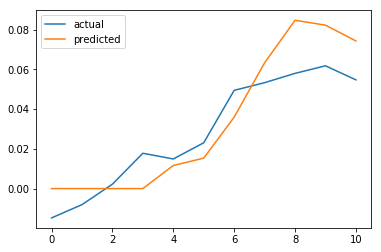

In [27]:
#bidirectional gru
def mean_pred(net_test_inputs, net_test_outputs):
    return K.mean(net_test_outputs)

# using rmsprop

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(GRU(neurons, go_backwards = True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(net_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(net_training_inputs, net_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(net_test_outputs, label = "actual")
plt.plot(nn_model.predict(net_test_inputs), label = "predicted")
plt.legend()
plt.show()

In [28]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 0s 44ms/step
Test accuracy: [0.013093788176774979, 0.0, 0.03338106721639633]


**PART G: NETWORK INITIAlIZATION**

Epoch 1/5
 - 28s - loss: 0.0278 - acc: 0.0025 - mean_pred: 0.0173
Epoch 2/5
 - 26s - loss: 0.0257 - acc: 0.0025 - mean_pred: 0.0190
Epoch 3/5
 - 27s - loss: 0.0254 - acc: 0.0025 - mean_pred: 0.0191
Epoch 4/5
 - 26s - loss: 0.0250 - acc: 0.0025 - mean_pred: 0.0190
Epoch 5/5
 - 26s - loss: 0.0250 - acc: 0.0025 - mean_pred: 0.0191


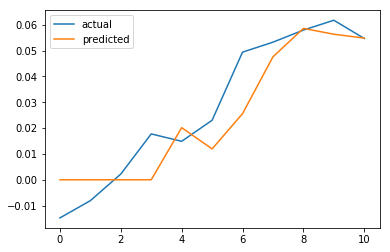

The Mean Absolute Error is: 0.008623059668208755


In [29]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using  random uniform as intializer
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [30]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 1s 49ms/step
Test accuracy: [0.008623059839010239, 0.0, 0.025005610659718513]


Epoch 1/5
 - 29s - loss: 0.0383 - acc: 0.0025 - mean_pred: 9.9366e-05
Epoch 2/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 3/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 4/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00
Epoch 5/5
 - 26s - loss: 0.0383 - acc: 0.0025 - mean_pred: 0.0000e+00


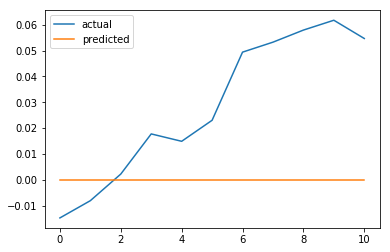

The Mean Absolute Error is: 0.032524172668289636


In [31]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using  zeros as intializer
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, bias_initializer='zeros'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [32]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 1s 52ms/step
Test accuracy: [0.032524172216653824, 0.0, 0.0]


Epoch 1/5
 - 28s - loss: 0.0301 - acc: 0.0025 - mean_pred: 0.0145
Epoch 2/5
 - 26s - loss: 0.0260 - acc: 0.0025 - mean_pred: 0.0188
Epoch 3/5
 - 26s - loss: 0.0254 - acc: 0.0025 - mean_pred: 0.0190
Epoch 4/5
 - 26s - loss: 0.0251 - acc: 0.0025 - mean_pred: 0.0190
Epoch 5/5
 - 26s - loss: 0.0250 - acc: 0.0025 - mean_pred: 0.0189


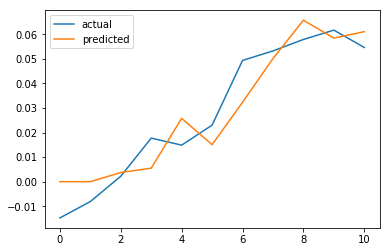

In [33]:
def mean_pred(LSTM_test_inputs, LSTM_test_outputs):
    return K.mean(LSTM_test_outputs)

#using orthogonal as intializer
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='orthogonal'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()


In [34]:
acc = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs, batch_size=16)
print('Test accuracy:', acc)

11/11 [==============================] - 1s 56ms/step
Test accuracy: [0.008465461432933807, 0.0, 0.028911704197525978]


**SUMMARY:
* **This is just showing how horrible nueral networks are at predicting stock prices without any reference(sentimental analysis) or any strategy.**
* **Using momentum and sentimental analysis we get far superior results.**
* **We can conclude that purely using LSTM and GRU networks doesn't do a great job at predicting values. So my earlier hypothesis that the LSTM cell should be capable of predicting the rise or fall in stock price given the window was very wrong.**
* **I failed to consider the speed of the moment and that the LSTM cell is well known for two things-problems with back propogation but more importantly holding values in the cell.**
* **Looking at how the values are plotting in the plateau graphs it becomes very clear that LSTM is able to predict value but with a lag- the lag being caused because it's cell retains short time memory. Using GRU (even though it doesn't have the same gate structure of LSTM) did not change much.**
* **Would convolutional neural nets do a better job? But they have filters and max pooling layers...again interconnected and multi-layered. If the LSTM cell is causing such a major lag the CNN will also take time.**
* **Unless I can make sure only certain neurons light up and classify whether my stock is going up or down...but then again by how much?**
* **It's ridiculous to keep muliclassifiers since stock fluctations are so tiny that I would have over thosands of classifiers...it makes no sense keeping classifiers like 100-150, 151-200....so many stock prices will reside between them...so CNN in its pure form is also pretty useless..**
* **The solution to this problem is feature extraction and loads of maths so that I create strategies with the input data and then smartly implement the mathmatical accuarcy of neural networks instead of using their native properies(like clasification or recurrent prediction)**
* **New hypothesis: create a trading strategy that focuses on a window, emphasizes on moving averages in values, freezes it(so that the "lag" problem doesn't arise) and then feed this as the input test data. One major problem....how to freeze data? what will indicate that the data must be stopped and analyzed? Additional tickers will be needed to be appeneded in the ohlcv dataset.**